In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from pprint import pprint

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
measurement_data = pd.read_sql("SELECT * FROM measurement", conn)
measurement_data.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


## Bonus Challenge Assignment: Temperature Analysis II

In [10]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2017-08-01', '2017-08-07'))

[(72.0, 79.25, 83.0)]


In [11]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

start_date = '2017-08-01'
end_date = '2017-08-07'

aug_temps = calc_temps(start_date, end_date)
temp_min, temp_avg, temp_max = aug_temps[0]

print("Here are your august trip's Weather Results!")
print(f" Min Temp : {temp_min} F")
print(f" Avg Temp : {temp_avg} F")
print(f" Max Temp : {temp_max} F")

Here are your august trip's Weather Results!
 Min Temp : 72.0 F
 Avg Temp : 79.25 F
 Max Temp : 83.0 F


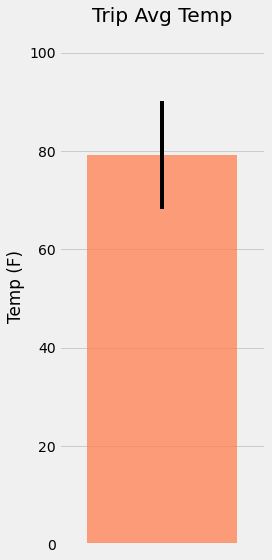

In [12]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

error = temp_max - temp_min
xpos = 1

plt.figure(figsize=(4, 8))
plt.bar(xpos, temp_avg, yerr=error, alpha=0.75, color="coral")
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.yticks(np.arange(0, 120, 20))
plt.tight_layout()
plt.xlim(0.45, 1.55)
plt.ylim(0, 105)
plt.savefig("Trip_Avg_Temp.png")

### Daily Rainfall Average

In [13]:
measurement_data.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [14]:
station_data = pd.read_sql("SELECT * FROM station", conn)
station_data

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [15]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2017-08-01'
end_date = '2017-08-07'

rain_station = (
    session.query(
        Station.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        func.avg(Measurement.prcp),
    )
    .filter(
        Measurement.station == Station.station,
        Measurement.date.between(start_date, end_date),
    )
    .group_by(Station.station)
    .order_by(func.avg(Measurement.prcp).desc())
    .all()
)


rain_df = pd.DataFrame(np.array(rain_station))
rain_df = rain_df.rename(
    columns={
        0: "Station",
        1: "Location",
        2: "Latitude",
        3: "Longitude",
        4: "Elevation",
        5: "Total Precipitation"
    }
)

rain_df

,Station,Location,Latitude,Longitude,Elevation,Total Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,0.12
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,0.03666666666666667
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84888999999998,32.9,0.02
3,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,0.005714285714285714
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.0


In [16]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [17]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
date_range = pd.date_range(start_date, end_date)

# Strip off the year and save a list of strings in the format %m-%d
date_list = [d.strftime("%m-%d") for d in date_range]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
daily_normal = [daily_normals(d)[0] for d in date_list]
pprint(daily_normal)


[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]


In [18]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates_df = pd.DataFrame(
    daily_normal, columns=["tmin", "tavg", "tmax"], index=date_range
)
trip_dates_df.index.name = "Date"
trip_dates_df

,tmin,tavg,tmax
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


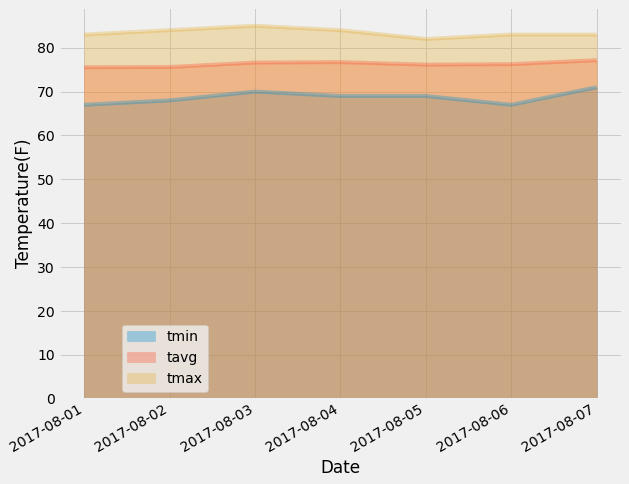

In [19]:
# Plot the daily normals as an area plot with `stacked=False`
trip_dates_df.plot(kind="area", stacked=False, x_compat=True, alpha=0.333, figsize=(9, 8))
plt.xlabel("Date")
plt.ylabel("Temperature(F)")
plt.legend(loc='lower left', bbox_to_anchor=(0.1, 0))
plt.savefig("area_plot.png")

## Close Session

In [20]:
session.close()